In [1]:
#2021.07.05. MON
#Hankyeong

#00. 패키지 호출
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import warnings 
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.linalg import toeplitz

#00-1. 시각화 옵션 설정
%matplotlib inline

#00-2. warning message ignore
warnings.filterwarnings(action='ignore')

#00-3. 씨드넘버 설정
np.random.seed(2021)
tf.random.set_seed(2021)


In [2]:
#04. 데이터셋 불러오기 및 전처리하기. 
#(1) 데이터셋 불러오기. 
article = pd.read_csv('../../data/ArticlesApril2018.csv', encoding='latin1')
article

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleadersâ Settlement Offer...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"âI understand that they could meet with us, ...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,Whatâs it like to eat at the second incarnat...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Torontoâs ...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,5ae82c93068401528a2ab969,1004,By CLAIRE CAIN MILLER,article,This Common Question Reinforces the Gender Pay...,"['Discrimination', 'Wages and Salaries', 'Labo...",68,Upshot,3,2018-05-01 09:00:01,Unknown,Several states and cities have ordered employe...,The New York Times,News,https://www.nytimes.com/2018/05/01/upshot/how-...
1320,5ae82c95068401528a2ab96b,1043,By TRACY J. GATES,article,"Anna, Llama and Me","['Friendship', 'Dewdney, Anna', 'Writing and W...",65,Well,0,2018-05-01 09:00:02,Family,"The beginning, middle and end of a picture boo...",The New York Times,News,https://www.nytimes.com/2018/05/01/well/family...
1321,5ae82c9d068401528a2ab96d,659,Interview by AUDIE CORNISH,article,Gen. Michael Hayden Has One Regret: Russia,"['Classified Information and State Secrets', '...",66,Magazine,70,2018-05-01 09:00:06,Unknown,"The former N.S.A. and C.I.A. chief on Trump, S...",The New York Times,News,https://www.nytimes.com/2018/05/01/magazine/ge...
1322,5ae82c9f068401528a2ab96f,1155,By JASON ROBERT BROWN,article,There Is Nothinâ Like a Tune,"['Books and Literature', 'Purdum, Todd S', 'Th...",68,BookReview,17,2018-05-01 09:00:07,Book Review,"In âSomething Wonderful,â Todd S. Purdum a...",The New York Times,Review,https://www.nytimes.com/2018/05/01/books/revie...


In [3]:
#(2) 데이터셋의 결측값 확인하기. 
article.isna().sum()

articleID           0
articleWordCount    0
byline              0
documentType        0
headline            0
keywords            0
multimedia          0
newDesk             0
printPage           0
pubDate             0
sectionName         0
snippet             0
source              0
typeOfMaterial      0
webURL              0
dtype: int64

In [4]:
#(2) 필요 변수만 추출하기. 
headlines = article['headline']
headlines

0       Former N.F.L. Cheerleadersâ Settlement Offer...
1       E.P.A. to Unveil a New Rule. Its Effect: Less ...
2                                 The New Noma, Explained
3                                                 Unknown
4                                                 Unknown
                              ...                        
1319    This Common Question Reinforces the Gender Pay...
1320                                   Anna, Llama and Me
1321           Gen. Michael Hayden Has One Regret: Russia
1322                       There Is Nothinâ Like a Tune
1323                                              Unknown
Name: headline, Length: 1324, dtype: object

In [5]:
#PLUS. 데이터프레임의 열 이름 확인하기. 
article.columns

Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

In [6]:
#(3) headlines 변수에 노이즈 데이터(Unknown) 제거하기. 
headlines[headlines=='Unknown'] = np.nan
headlines = headlines.dropna()
headlines

0       Former N.F.L. Cheerleadersâ Settlement Offer...
1       E.P.A. to Unveil a New Rule. Its Effect: Less ...
2                                 The New Noma, Explained
8       How a Bag of Texas Dirt  Became a Times Tradition
9                  Is School a Place for Self-Expression?
                              ...                        
1318    Dear Match Book: Fiction that Takes Us Back to...
1319    This Common Question Reinforces the Gender Pay...
1320                                   Anna, Llama and Me
1321           Gen. Michael Hayden Has One Regret: Russia
1322                       There Is Nothinâ Like a Tune
Name: headline, Length: 1214, dtype: object

In [7]:
#(4) 소문자, 특수기호 처리하기.   
headlines_pre = [] 
for headline in headlines :
    headline_pre = re.sub('[^A-Za-z ]','',headline).lower()
    headlines_pre.append(headline_pre)

#(5) 처리 된 headline 확인하기. 
headlines_pre[:5]

['former nfl cheerleaders settlement offer  and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [8]:
#(6) Tonkenizer 객체 지정하기. 
tokenizer = Tokenizer()

#(7) 토큰화하기. 
tokenizer.fit_on_texts(headlines)

#(8) 단어집합 설정하기. 
voca_size = len(tokenizer.word_index) +1 
voca_size

3596

In [9]:
#(9) headlines에 대해 정수 인코딩하기. 
sequences = []
for line in headlines_pre :
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

#(10) 10개의 sample 출력하기.  
sequences[:10]

[[104, 839],
 [104, 839, 1129],
 [104, 839, 1129, 595],
 [104, 839, 1129, 595, 7],
 [104, 839, 1129, 595, 7, 2],
 [104, 839, 1129, 595, 7, 2, 390],
 [104, 839, 1129, 595, 7, 2, 390, 10],
 [104, 839, 1129, 595, 7, 2, 390, 10, 1130],
 [3, 1131],
 [3, 1131, 2]]

In [10]:
#(11) 패딩 처리 전 sequence의 최대 원소 수 파악하기.
max_len = max(len(s) for s in sequences)
max_len

20

In [11]:
#(12) 패딩 처리하기. 
sequences_pad = pad_sequences(sequences, maxlen=max_len, padding='pre')
sequences_pad

array([[   0,    0,    0, ...,    0,  104,  839],
       [   0,    0,    0, ...,  104,  839, 1129],
       [   0,    0,    0, ...,  839, 1129,  595],
       ...,
       [   0,    0,    0, ...,  234,    9,  117],
       [   0,    0,    0, ...,    9,  117,    2],
       [   0,    0,    0, ...,  117,    2, 1041]])

In [12]:
#(13) feature, target 데이터셋으로 분할하기. 
X = sequences_pad[:,:-1]
y = sequences_pad[:,-1]

#(14) target 변수 원핫인코딩 처리하기. 
Y = to_categorical(y, num_classes=voca_size)

#(15) feature, target 변수 차원 확인하기. 
X.shape, Y.shape

((7290, 19), (7290, 3596))

In [13]:
#05. GRU을 이용해 텍스트 (미리보기) 생성하기. 
#(1) 모델 정의하기. 
model = Sequential([
    Embedding(voca_size, 10, input_length=max_len-1),
    GRU(128),
    Dense(voca_size, activation='softmax')
])

#(2) 모델의 요약정보 확인하기. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 10)            35960     
_________________________________________________________________
gru (GRU)                    (None, 128)               53760     
_________________________________________________________________
dense (Dense)                (None, 3596)              463884    
Total params: 553,604
Trainable params: 553,604
Non-trainable params: 0
_________________________________________________________________


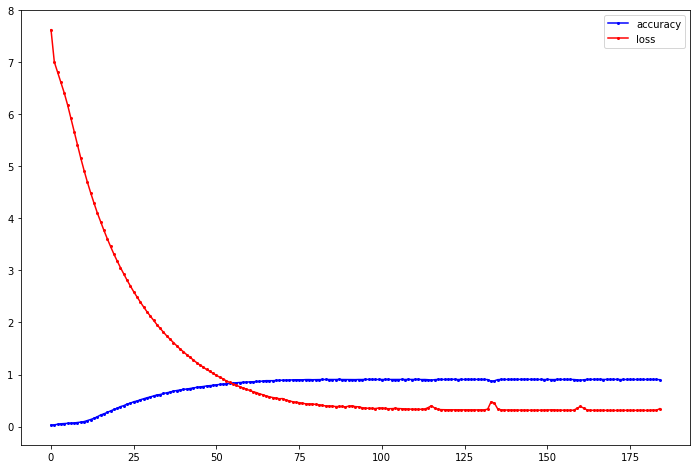

In [14]:
#(3) 모델의 compile 설정하기. 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics='accuracy'
)

#(4) checkpointer 객체 정의하기. 
MODEL_PATH = '../../model/NYTC_best_GRU_model.h5'
checkpointer = ModelCheckpoint(
    filepath = MODEL_PATH,
    monitor  = 'loss',
    save_best_only = True,
    verbose = 0
)

#(5) earlystopping 객체 할당하기. 
earlystopping = EarlyStopping(monitor='loss',patience=15)

#(6) 모델 학습하기. 
model_fit = model.fit(
    X, 
    Y,
    epochs=2500,
    callbacks=[checkpointer, earlystopping],
    verbose=0
)

#(7) 모델의 학습 과정 시각화하기. 
y_loss = model_fit.history['loss']
y_accuracy = model_fit.history['accuracy']
x_len = np.arange(len(y_loss))
plt.figure(figsize=(12,8))
plt.plot(x_len, y_accuracy, 'bo-', markersize=2, label='accuracy')
plt.plot(x_len, y_loss, 'ro-', markersize=2, label='loss')
plt.legend()
plt.show()

In [15]:
#06. 모델 검증하기. 
#(1) 검증용 함수 정의하기. (by github.com/ckiekim)
def sentence_generation(model, tokenizer, max_len, current_word, n)         : 
    init_word = current_word 
    best_model = load_model(MODEL_PATH)
    sentence = ''
    for _ in range(n)                                                       : 
        encoded = tokenizer.texts_to_sequences([current_word])[0] 
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre') 
        result = best_model.predict_classes(encoded, verbose=0)
        for word, index in tokenizer.word_index.items(): 
            if index == result                                              :
                break 
        current_word = current_word + ' ' + word 
        sentence = sentence + ' ' + word 
    sentence = init_word + sentence
    return sentence

#(2) 검증하기.
sentence_generation(model, tokenizer, max_len, 'i', 10)

'i disapprove of school vouchers can i still apply for them'

In [16]:
sentence_generation(model, tokenizer, max_len, 'epa', 10)

'epa and underwear for all now to endless as it border'

In [17]:
sentence_generation(model, tokenizer, max_len, 'former', 10)

'former judge to review files seized in searches trump to think'

In [18]:
sentence_generation(model, tokenizer, max_len, 'how', 10)

'how to make a crossword puzzle stoically defying currency art to'